# Script for calculating daily tas (surface air temperature) statistics

In [172]:
import numpy
import scipy.stats
import netCDF4

import matplotlib.patches
import matplotlib.gridspec
import datetime as dt

import matplotlib.pyplot as mp
%matplotlib inline

degree_sign = '\N{DEGREE SIGN}'

In [173]:
#Hack to fix missing PROJ4 env var
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
 
from mpl_toolkits import basemap

# Set up details of analysis

### Declare the root directory and names of the files you want to open

* Note 3 different time periods have been set up for these data: 
 * __hist__           (1980-2010) for CMIP6 models,(1970-2000) for CMIP5 models
 * __early_century__  (2015-2045) for CMIP6 models,(2005-2035) for CMIP5 models
 * __late_century__   (2070-2100)
 * the data put out by the different modeling centers comes in different time blocks so we have preprocessed it after download from the ESGF to have these time periods for simplicity. 
 * CMIP6 model projections are for SSP5-8.5 (Shared Socioeconomic Pathway for greenhouse gas and aerosol forcings)
 * CMIP5 model projections are for RCP 8.5 (Representative Concentration Pathway)
  * Note that the SSP starts later than the data for the RCP so the early century time periods don't match

### You can choose which model to analyze

Do this by changing model_index= to a value 0 through 5. Values 0 through 3 are CMIP6 models; 4, 5 are CMIP5 models.

### You can to choose whether you use the (2070-2100) or (2005-2035)/(2015-2045) time periods

Do this by selecting **`late_century = True`** or **`early_century = True`** below


In [174]:
#acronyms for climate models for which daily temp. and prec. data has been downloaded from selected simulations

model_names = ['CESM2-WACCM', 
               'GFDL-CM4',
               'MPI-ESM1-2-LR',
               'MRI-ESM2',
              'CESM1-CAM5',
               'GFDL-CM3',
              ]

In [175]:
################ Choose model #####################

model_index = 2

# 0 CESM2-WACCM
# 1 GFDL-CM4
# 2 MPI-ESM-2-LR
# 3 MRI-ESM2
# 4 CESM-CAM5 (CMIP5)
# 5 GFDL-CM3 (CMIP5)

cmip6 = model_index< 4     #a Boolean variable used for handling differences between CMIP5 and CMIP6 data
model_name = model_names[model_index]

#a string for use in labels later
if cmip6:
    scenario = 'SSP5-8.5'
else:
        scenario ='RCP8.5'
print ('model_name  ',model_name,';   scenario ',scenario)

model_name   MPI-ESM1-2-LR ;   scenario  SSP5-8.5


In [176]:
# specify whether you want to use the early or late period

late_century, early_century   = True, False # selects 2070 - 2100 
#early_century, late_century  = True, False # selects 2015 - 2045 for CMIP6 models, 2005 - 2035 for CMIP5 models


In [177]:
#not yet implemented for temperature analysis, could import from Precip notebook
#specify whether you want to use a land mask i.e., within your region only include land points
#True for landmasking, that is only include events over land
#maskit = True


### Choose season for analysis (or create your own)

In [178]:
# SEASONS

#season='DJF'; months=[12,1,2]
#season='MAM'; months=[3,4,5]
season='JJA'; months=[6,7,8]
#season='SON'; months=[9,10,11]
#season='annual'; months=[1,2,3,4,5,6,7,8,9,10,11,12]

### Get the file names corresponding to the details you chose

In [179]:
file_root = '/home/datasets/aos112_2020/AOS112_Lab_2_Extreme_daily_data/' + ('cmip6/' if cmip6 else 'cmip5/')
file_root_obs = '/home/datasets/aos112_2020/AOS112_Lab_2_Extreme_daily_data/observations/'



hist_filename      = 'tas_day_' + model_names[model_index] + '_historical_r1i1p1_' \
                        + ('19800101-20091231.nc' if cmip6 else '19710101-20001131.nc')

ssp_early_filename = 'tas_day_' + model_names[model_index] + ('_ssp585_' if cmip6 else '_rcp85_') + 'r1i1p1_' \
                        + ('20150101-20441231.nc' if cmip6 else '20060101-20351231.nc')

ssp_late_filename  = 'tas_day_' + model_names[model_index] + ('_ssp585_' if cmip6 else '_rcp85_') + 'r1i1p1_' \
                        + ('20700101-20991231.nc' if cmip6 else '20710101-21001231.nc')



#  list files to check the paths are correct 
!ls $file_root_obs$obs_filename
!ls $file_root$hist_filename
!ls $file_root$rcp_early_filename
!ls $file_root$rcp_late_filename

#!ls $file_root #uncomment this line to see all model filenames

aos112_lab2_daily_pr_bak.ipynb	 aos112_lab2_daily_tas_bak.ipynb
aos112_lab2_daily_pr-del1.ipynb  aos112_lab2_daily_tas.ipynb
aos112_lab2_daily_pr.ipynb
/home/datasets/aos112_2020/AOS112_Lab_2_Extreme_daily_data/cmip6/tas_day_MPI-ESM1-2-LR_historical_r1i1p1_19800101-20091231.nc
aos112_lab2_daily_pr_bak.ipynb	 aos112_lab2_daily_tas_bak.ipynb
aos112_lab2_daily_pr-del1.ipynb  aos112_lab2_daily_tas.ipynb
aos112_lab2_daily_pr.ipynb
aos112_lab2_daily_pr_bak.ipynb	 aos112_lab2_daily_tas_bak.ipynb
aos112_lab2_daily_pr-del1.ipynb  aos112_lab2_daily_tas.ipynb
aos112_lab2_daily_pr.ipynb


### Define the region to analyze (use one that's there, or create your own)
- you can check the map in the next cell to see if the boundaries are where you want, and adjust if needed
- give your region a mnemonic name for labels on plots later

In [180]:
#Example regions
#lat_lo = 30; lat_hi = 45; lon_lo = 230; lon_hi = 250; region='California'
lat_lo = 35; lat_hi = 45; lon_lo = 255; lon_hi = 275; region='Central US'
#lat_lo = -45; lat_hi = -10.; lon_lo = 110; lon_hi = 156; region='Australia'
#lat_lo = -10; lat_hi = 10; lon_lo = -25; lon_hi = 60; region='Equatorial Africa'
#lat_lo = 40; lat_hi = 60; lon_lo = 80; lon_hi = 110; region='Central Asia'
#lat_lo = -10; lat_hi = 10; lon_lo = 160; lon_hi = 240; region='Tropical Pacific'
#lat_lo = 75; lat_hi = 90; lon_lo = 0; lon_hi = 360; region='Arctic Circle'
#lat_lo = 20; lat_hi = 35; lon_lo = 100; lon_hi = 120; region='SE China'

#Change this line or replace with one from above (without # sign) to change region
#lat_lo = 35; lat_hi = 45; lon_lo = 255; lon_hi = 275; region='Central US'

### Plot this latitude/longitude range to visualize it

Text(0.5, 1.1, 'Central US')

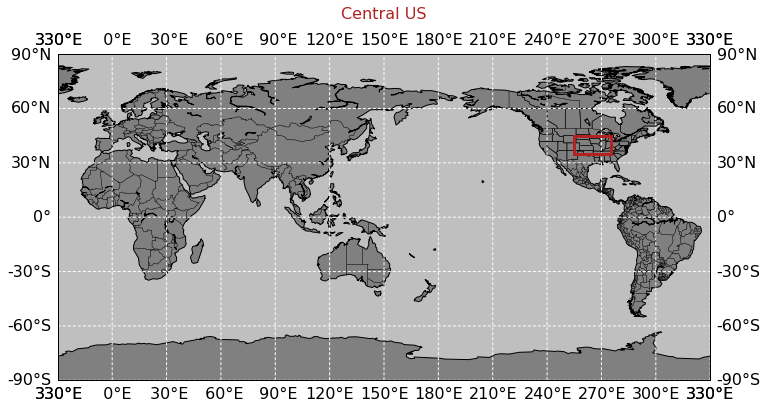

In [181]:
def format_lons(lon):
    return '%3d' % lon + '\N{DEGREE SIGN}E'
def format_lats(lat):
    if lat<0:
        return '%2d' % lat + '\N{DEGREE SIGN}S'
    elif lat==0:
        return '%1d' % lat + '\N{DEGREE SIGN}'
    elif lat>0:
        return '%2d' % lat + '\N{DEGREE SIGN}N'
    
region_lats = [lat_lo, lat_hi, lat_hi, lat_lo]
region_lons = [lon_lo, lon_hi, lon_hi, lon_lo]

fontsize=16

fig = mp.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ax_map = basemap.Basemap(projection='cyl', ax=ax, llcrnrlon=-30., llcrnrlat=-90., urcrnrlon=330., urcrnrlat=90.)
ax_map.drawcoastlines()
ax_map.fillcontinents(color='0.5', lake_color='0.75')
ax_map.drawmapboundary(fill_color='0.75')
ax_map.drawstates()
ax_map.drawcountries()

ax_map.drawparallels(numpy.arange(-90,91,30), labels=[1,1,1,1], dashes=[3,2], fontsize=fontsize, fmt=format_lats, color='1')
ax_map.drawmeridians(numpy.arange(-30,341,30), labels=[1,1,1,1], dashes=[3,2], fontsize=fontsize, fmt=format_lons, color='1')

x1,y1 = ax_map(lon_lo, lat_lo)
x2,y2 = ax_map(lon_lo, lat_hi)
x3,y3 = ax_map(lon_hi, lat_hi)
x4,y4 = ax_map(lon_hi, lat_lo)
poly = matplotlib.patches.Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],facecolor='None',\
                                  edgecolor='firebrick',linewidth=3,zorder=3)
mp.gca().add_patch(poly)

ax.text(s=region, x=0.5, y=1.1, ha='center', va='bottom', transform=ax.transAxes, fontsize=fontsize, color='firebrick')

### Open the data you selected above
- This cell takes a minute to run due to large data sets

In [182]:
# open historical
ncfile_hist = netCDF4.Dataset(file_root + hist_filename, 'r', format='NETCDF4')
time_variable_hist = ncfile_hist.variables['time']
time_variable_hist_converted = netCDF4.num2date(time_variable_hist[:], time_variable_hist.units, time_variable_hist.calendar)

# open ssp 8.5
if late_century: # if ssp_late=True, open the later time frame (2070-2100)
    ncfile_ssp = netCDF4.Dataset(file_root + ssp_late_filename, 'r', format='NETCDF4')
    ssp_years = '2071-2100'
    hist_years = '1970-2000'
else: # otherwise, open the earlier time frame (2005-2035)
    ncfile_ssp = netCDF4.Dataset(file_root + ssp_early_filename, 'r', format='NETCDF4')
    ssp_years = '2006-2035'
    hist_years = '1971-2000'

time_variable_ssp = ncfile_ssp.variables['time']
time_variable_ssp_converted = netCDF4.num2date(time_variable_ssp[:], time_variable_ssp.units, time_variable_ssp.calendar)

model_lat = ncfile_hist.variables['lat'][:]
model_lon = ncfile_hist.variables['lon'][:]

### Get latitude and longitude values where the region is located

In [183]:
model_lon_indices = (model_lon>=lon_lo) & (model_lon<=lon_hi)
model_lat_indices = (model_lat>=lat_lo) & (model_lat<=lat_hi)

### Define the time periods to analyze

In [184]:
# historical
hist_start   = dt.datetime(1970,1,1)
hist_end     = dt.datetime(2000,1,1)
# SSP585
if late_century:
    ssp_start   = dt.datetime(2070,1,1)
    ssp_end     = dt.datetime(2099,12,31)
else:
    ssp_start = dt.datetime(2015,1,1)
    ssp_end = dt.datetime(2034,12,31)

### Code to pull out proper time, latitudes, and longitudes
- This cell takes a while to run due to large data sets

In [185]:
time_indices_hist = numpy.array([(t.month in months)&(t.year in range(hist_start.year, hist_end.year+1)) for t in time_variable_hist_converted])
time_indices_ssp = numpy.array([(t.month in months)&(t.year in range(ssp_start.year, ssp_end.year+1)) for t in time_variable_ssp_converted])

# (variable name _pr inherited from code in precip notebook but it's tas here)
model_hist_pr = ncfile_hist.variables['tas'][time_indices_hist,:,:][:,model_lat_indices,:][:,:,model_lon_indices]
model_ssp_pr = ncfile_ssp.variables['tas'][time_indices_ssp,:,:][:,model_lat_indices,:][:,:,model_lon_indices]

print ('time_indices and model_hist, _ssp tas data arranged')

time_indices and model_hist, _ssp tas data arranged


# ==================================================
# Histograms of daily surface air temperature
# ==================================================

### Calculate the means of the time periods for your region
 * Note that even though you start with daily data, this will be the mean over the season and decades that you chose, as well as over all grid points in the region you chose, so this is like the quantities computed in  Lab 1
 * Detail: the mean over the region is not an area-weighted average

In [186]:
hist_mean = numpy.mean(model_hist_pr)
ssp_mean = numpy.mean(model_ssp_pr)

#values rounded to 2 decimal places
print(str(round(hist_mean,2))+' K'+' is the mean for historical')
print(str(round(ssp_mean,2))+' K'+' is the mean for ', scenario)

295.9 K is the mean for historical
302.49 K is the mean for  SSP5-8.5


### Compute your favorite percentile in each time period

In [187]:
perc_hi = 99. # 99th percentile
perc_lo = 1. # 1st percentile

value_hi_hist = scipy.stats.scoreatpercentile(model_hist_pr, perc_hi)
value_lo_hist = scipy.stats.scoreatpercentile(model_hist_pr, perc_lo)

value_hi_ssp = scipy.stats.scoreatpercentile(model_ssp_pr, perc_hi)
value_lo_ssp = scipy.stats.scoreatpercentile(model_ssp_pr, perc_lo)

### Print out these percentiles; how is the distribution changing?

In [188]:
print(str(round(value_hi_hist,2))+' K'+' is the '+str(perc_hi)+'th percentile for historical')
print(str(round(value_hi_ssp,2))+' K'+' is the '+str(perc_hi)+'th percentile for ssp 8.5')
print()
print(str(round(value_lo_hist,2))+' K'+' is the '+str(perc_lo)+'th percentile for historical')
print(str(round(value_lo_ssp,2))+' K'+' is the '+str(perc_lo)+'th percentile for ssp 8.5')

308.35 K is the 99.0th percentile for historical
314.69 K is the 99.0th percentile for ssp 8.5

285.91 K is the 1.0th percentile for historical
290.8 K is the 1.0th percentile for ssp 8.5


### Define the bins and calculate the histograms

* Note that `density=True` means the resulting histogram will be a probability density function (frequency of occurrence normalized by total counts and by bin width).
* Setting `density=False` will give you the counts alone, and you can normalize this later as needed.
* default (bins=numpy.logspace...) uses bins that are constant in log(temperature) (i.e., they get wider for higher temperature). This helps to have enough  values per bin to have statistical significance at high temperature.
* can also reduce the number of bins to have more counts per bin 

In [189]:
Nbins=90 #100  #sets the number of bins for the histogram
bin_lo=210 #sets the lowest bin value
#  binning range set by the maximum value encountered times a factor slightly larger than one  e.g., 1.1 
bins = numpy.linspace(bin_lo,model_ssp_pr.max(),Nbins) # linearly spaced bins
hist_histogram, bin_edges = numpy.histogram(model_hist_pr, bins=bins, density=True)
ssp_histogram, bin_edges = numpy.histogram(model_ssp_pr, bins=bins, density=True)

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = numpy.diff(bin_edges)

### Make histogram plots (linear y-scale)
 * with mean of the distribution shown on plot 

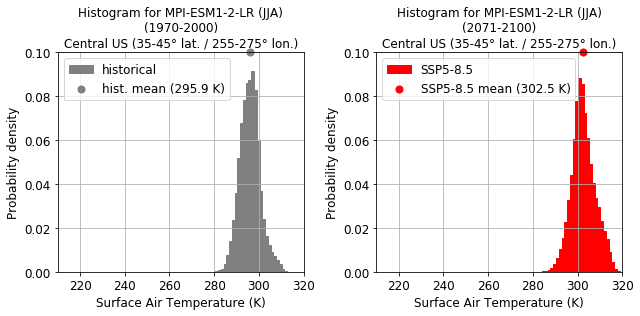

In [190]:
fig = mp.figure(figsize=(9,4.5))
fontsize=12
ymax=0.1 #sets the yscale for the figure; to zoom in y, change this value, e.g., ymax=.05

ax1 = fig.add_subplot(121)
ax1.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0.5', edgecolor='0.5', label='historical')
ax1.set_xlim(bins[0], bins[-1])  #only showing x-axis up to given value 
ax1.set_ylim(0, ymax)
ax1.tick_params(labelsize=fontsize)
ax1.set_ylabel('Probability density', fontsize=fontsize)
ax1.set_xlabel('Surface Air Temperature (K)', fontsize=fontsize)
ax1.set_title('Histogram for '+model_name+' ('+season+')'+'\n('+hist_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax1.scatter(x=hist_mean, y=ymax, s=50, marker='o', clip_on=False, color='0.5', label='hist. mean ('+'{0:.1f}'.format(hist_mean)+' K)')
ax1.grid()

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax2 = fig.add_subplot(122)
ax2.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', edgecolor='red', label=scenario)
ax2.set_xlim(bins[0], bins[-1])
ax2.set_ylim(0, ymax)
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel('Probability density', fontsize=fontsize)
ax2.set_xlabel('Surface Air Temperature (K)', fontsize=fontsize)
ax2.set_title('Histogram for '+model_name+' ('+season+')'+'\n('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax2.scatter(x=ssp_mean, y=ymax, s=50, marker='o', clip_on=False, c='red', label=scenario +' mean ('+'{0:.1f}'.format(ssp_mean)+' K)')
ax2.grid()

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

fig.tight_layout()

### Make combined, linear y-scale plot

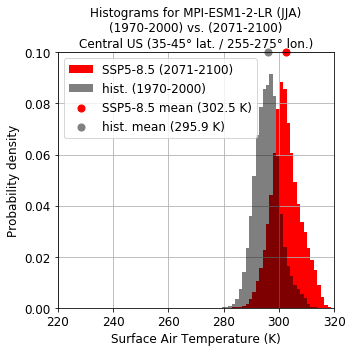

In [191]:
fig = mp.figure(figsize=(5,5))
fontsize=12
xmin=220  # to zoom in x, change this value
xmax=320  # to zoom in x, change this value
ymax=0.1 #sets the yscale for the figure; to zoom in y, change this value, e.g., ymax=.05

ax = fig.add_subplot(111)
ax.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0', lw=0, label='hist. ('+hist_years+')', zorder=1, alpha=0.5)
ax.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', lw=0, label=scenario +' ('+ssp_years+')', zorder=0)
ax.set_xlim(xmin, xmax) 
ax.set_ylim(0, ymax)
ax.set_ylabel('Probability density', fontsize=fontsize)
ax.set_xlabel('Surface Air Temperature (K)', fontsize=fontsize)
ax.set_title('Histograms for '+model_name+' ('+season+')'+'\n('+hist_years+') vs. ('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)

# add means
ax.scatter(x=hist_mean, y=ymax, s=50, marker='o', clip_on=False, color='0.5', label='hist. mean ('+'{0:.1f}'.format(hist_mean)+' K)')
ax.scatter(x=ssp_mean, y=ymax, s=50, marker='o', clip_on=False, c='red', label=scenario +' mean ('+'{0:.1f}'.format(ssp_mean)+' K)')

ax.tick_params(labelsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax.set_axisbelow(True)
ax.grid()
fig.tight_layout()

### Make histogram plots showing mean and high percentile with log y-axis option
* marks the mean value with a dot and your chosen high percentile value with a vertical line
* linear scale is shown if log_y_axis=False
* log y-scale plots are less useful for temperature than for precipitation unless you want to see really low probability events, or check if the distribution is close to Gaussian
* if you want to turn off a code cell change it to a non-code cell type (to turn it on/off, click in it and then choose Cell>cell type>code or raw).

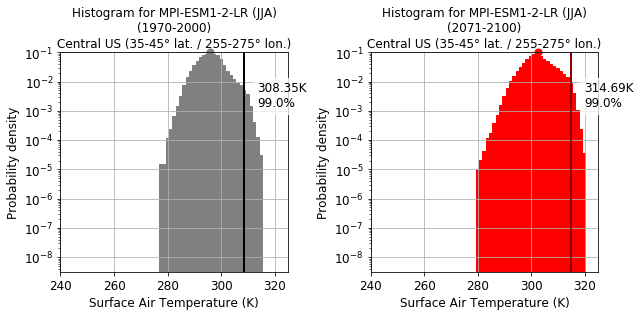

In [192]:
log_y_axis=True  #set this to False for a linear y-axis showing the high percentile
fig = mp.figure(figsize=(9,4.5))
fontsize=12
xmin=240  # to zoom in x, change this value
xmax=325  # to zoom in x, change this value
ymax=0.1 #sets the yscale for the figure

ax1 = fig.add_subplot(121)
ax1.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0.5', edgecolor='0.5', label='historical')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(10**-8.5, ymax)
ax1.tick_params(labelsize=fontsize)
ax1.set_ylabel('Probability density', fontsize=fontsize)
ax1.set_xlabel('Surface Air Temperature (K)', fontsize=fontsize)
if log_y_axis:
    ax1.set_yscale('log')   #if uncommented, this sets the log y-scale (first subplot)
ax1.set_title('Histogram for '+model_name+' ('+season+')'+'\n('+hist_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax1.axvline(value_hi_hist, lw=2, c='0')
t=ax1.text(s='{:.2f}'.format(value_hi_hist)+'K\n'+str(perc_hi)+'%', ha='left', va='top', x=value_hi_hist+5, y=10**-2, fontsize=fontsize)
t.set_bbox(dict(color='1', alpha=0.75))
ax1.scatter(x=hist_mean, y=ymax, s=50, marker='o', clip_on=False, color='0.5', label='hist. mean ('+'{0:.1f}'.format(hist_mean)+' mm/day)')
ax1.grid()
#legend not showing so don't see labels

ax2 = fig.add_subplot(122)
ax2.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', edgecolor='red', label=scenario)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(10**-8.5, ymax)
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel('Probability density', fontsize=fontsize)
ax2.set_xlabel('Surface Air Temperature (K)', fontsize=fontsize)
if log_y_axis:
    ax2.set_yscale('log')    #if uncommented, this sets log y-scale (second subplot)
ax2.set_title('Histogram for '+model_name+' ('+season+')'+'\n('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax2.axvline(value_hi_ssp, lw=2, c='darkred')
t=ax2.text(s='{:.2f}'.format(value_hi_ssp)+'K\n'+str(perc_hi)+'%', ha='left', va='top', x=value_hi_ssp+5, y=10**-2, fontsize=fontsize)
t.set_bbox(dict(color='1', alpha=0.75))
ax2.scatter(x=ssp_mean, y=ymax, s=50, marker='o', clip_on=False, c='red', label=scenario +' mean ('+'{0:.1f}'.format(ssp_mean)+' mm/day)')
ax2.grid()

fig.tight_layout()

### Make combined histogram plot showing high percentile, with option for log y-scale 
 * marks the mean value with a dot and your chosen high percentile value with a vertical line
 * linear scale is shown if log_y_axis=False
 * log y-scale plots are less useful for temperature than precipitation unless you want to see really low probability events, or check if the distribution is close to Gaussian
 * A Gaussian distribution will look like an upside down parabola

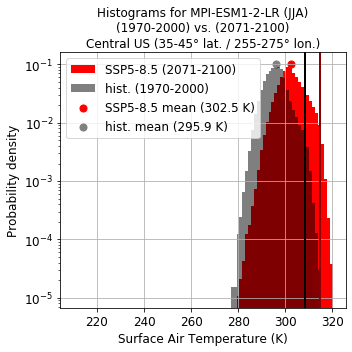

In [193]:
#log_y_axis=True  #value has been set above; on comment to set here. False for a linear y-axis 
fig = mp.figure(figsize=(5,5))
fontsize=12
xmin=240  # to zoom in x, change this value
xmax=325  # to zoom in x, change this value
ymax=0.1 #sets the yscale for the figure

ax = fig.add_subplot(111)
ax.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0', lw=0, label='hist. ('+hist_years+')', zorder=1, alpha=0.5)
ax.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', lw=0, label=scenario +' ('+ssp_years+')', zorder=0)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(10**-8.5, ymax)
ax.set_ylabel('Probability density', fontsize=fontsize)
ax.set_xlabel('Surface Air Temperature (K)', fontsize=fontsize)
ax.set_title('Histograms for '+model_name+' ('+season+')'+'\n('+hist_years+') vs. ('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)

ax.scatter(x=hist_mean, y=ymax, s=50, marker='o', clip_on=False, color='0.5', label='hist. mean ('+'{0:.1f}'.format(hist_mean)+' K)')
ax.scatter(x=ssp_mean, y=ymax, s=50, marker='o', clip_on=False, color='red', label=scenario +' mean ('+'{0:.1f}'.format(ssp_mean)+' K)')
ax.axvline(value_hi_hist, lw=2, c='0')
ax.axvline(value_hi_ssp, lw=2, c='darkred')

if log_y_axis:
    ax.set_yscale('log') # use log scale
ax.tick_params(labelsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax.grid()
fig.tight_layout()

### Calculate the change of the mean of the distributions

In [194]:
print('Difference between mean for', scenario,'and historical =',str(round (ssp_mean-hist_mean, 2)),'K')

Difference between mean for SSP5-8.5 and historical = 6.59 K


### Calculate how the value at a given historical percentile changes in the ssp 8.5 runs

In [195]:
perc_in_hist = perc_hi # set above, but change here if desired

# calculate the value (in degrees Celsius) that is at the 99th percentile
value_hist = scipy.stats.scoreatpercentile(model_hist_pr, perc_in_hist)
print('HISTORICAL: ', '{:.1f}'.format(value_hist)+' K'+' is the '+str(perc_in_hist)+'th percentile')

# now calculate how the probability of this event changes in ssp 8.5
perc_in_ssp = scipy.stats.percentileofscore(model_ssp_pr.flatten(), value_hist)
print('FUTURE:     ', '{:.2f}'.format(perc_in_ssp)+'% is the percentile for this value in ', scenario)

print()

# calculate the fractional increase in likelihood
fraction = (100-perc_in_ssp)/(100-perc_in_hist)
print('This temperature value has become '+'{:.2f}'.format(fraction)+' times as likely in', scenario,'relative to historical')

HISTORICAL:  308.3 K is the 99.0th percentile
FUTURE:      85.59% is the percentile for this value in  SSP5-8.5

This temperature value has become 14.41 times as likely in SSP5-8.5 relative to historical


### Count the number of occurrences above this percentile value

* Approximate by counting events above this percentile value

In [196]:
print('HISTORICAL: ', numpy.sum(model_hist_pr>=value_hist),'is the number of hot days above the',perc_in_hist,'th percentile of '+str(round(value_hist, 2)),'K')
print('FUTURE:     ', numpy.sum(model_ssp_pr>=value_hist),'is the number of hot days above the historical',perc_in_hist,'th percentile for', scenario)
print()
print('{:.1f}'.format(numpy.sum(model_ssp_pr>=value_hist)/numpy.sum(model_hist_pr>=value_hist)),'is the ratio of ', scenario,' to historical days above this threshold')

HISTORICAL:  1063 is the number of hot days above the 99.0 th percentile of 308.35 K
FUTURE:      21868 is the number of hot days above the historical 99.0 th percentile for SSP5-8.5

20.6 is the ratio of  SSP5-8.5  to historical days above this threshold


# ==================================================
# Extreme value calculations
# ==================================================

### Before we do any calculations, let's visualize what annual extremes look like

* Do this for the historical time period, from 1995 to 2000, for the middle lat/lon in the series

In [197]:
# subset time indices
time_array_hist = time_variable_hist_converted[time_indices_hist]
time_array_ssp = time_variable_ssp_converted[time_indices_ssp]

In [198]:
middle_lat = round(model_hist_pr.shape[1]/2)
middle_lon = round(model_hist_pr.shape[2]/2)

start = 1990
end = 1995 # must not go above 2001
nyears = end-start

# subset time between two years
year_indices_time_span = [t.year in range(start, end) for t in time_array_hist]
time_array_time_span = numpy.array(([dt.datetime(t.year,t.month,t.day) \
                                     for t in time_array_hist[year_indices_time_span]]))
model_hist_pr_time_span = model_hist_pr[year_indices_time_span, middle_lat, middle_lon]

max_precip_time_span = []
max_precip_time_span_dates = []

for year_idx in range(nyears):
    current_year = time_array_time_span[0].year+year_idx
    year_indices = numpy.array([t.year==current_year for t in time_array_time_span]) # true when current year
    max_precip_time_span.append(numpy.max(model_hist_pr_time_span[year_indices]))
    max_idx = int(numpy.argmax(model_hist_pr_time_span[year_indices]))
    max_precip_time_span_dates.append(time_array_time_span[year_indices][max_idx])

Coastlines not drawm


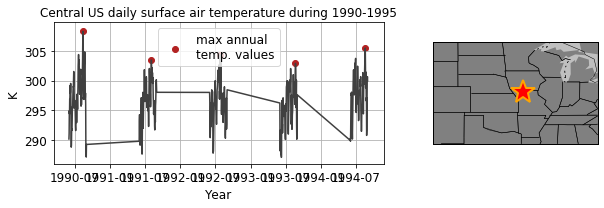

In [199]:
fontsize = 12

grid_lat = model_lat[model_lat_indices][middle_lat]
grid_lon = model_lon[model_lon_indices][middle_lon]

fig = mp.figure(figsize=(8.5,3))

gs = matplotlib.gridspec.GridSpec(1,2, width_ratios=[2,1]) 
ax1 = mp.subplot(gs[0])
ax2 = mp.subplot(gs[1])


ax1.plot(time_array_time_span, model_hist_pr_time_span, c='0.25')
ax1.scatter(max_precip_time_span_dates, max_precip_time_span, color='firebrick', label='max annual\ntemp. values')
ax1.tick_params(labelsize=fontsize)
ax1.set_title(region + ' daily surface air temperature during '+str(start)+'-'+str(end), fontsize=fontsize)
ax1.set_xlabel('Year', fontsize=fontsize)
ax1.set_ylabel('K', fontsize=fontsize)
ax1.grid()
legend = ax1.legend(fontsize=fontsize)

ax_map = basemap.Basemap(projection='cyl', ax=ax2, \
                      llcrnrlon=lon_lo-3, \
                      llcrnrlat=lat_lo-3, \
                      urcrnrlon=lon_hi+3, \
                      urcrnrlat=lat_hi+3)
try:
    ax_map.drawcoastlines()
except ValueError:
    print('Coastlines not drawm')
    



ax_map.fillcontinents(color='0.5', lake_color='0.75')
ax_map.drawmapboundary(fill_color='0.75')
ax_map.drawstates()
ax_map.drawcountries()
ax_map.plot(grid_lon, grid_lat, marker='*', markeredgecolor='orange', markeredgewidth=2, \
            markerfacecolor='red', markersize=25)


fig.tight_layout()

### Collect annual max values for historical temperature

In [200]:
nyears_hist = time_array_hist[-1].year-time_array_hist[0].year+1
nyears_ssp = time_array_ssp[-1].year-time_array_ssp[0].year+1
#if obs:  nyears_obs = time_array_obs[-1].year-time_array_obs[0].year+1

annual_max_hist_pr = numpy.zeros((nyears_hist, \
                                  sum(model_lat_indices), \
                                  sum(model_lon_indices)))

annual_max_ssp_pr = numpy.zeros((nyears_ssp, \
                                 sum(model_lat_indices), \
                                 sum(model_lon_indices)))

# loop through each year from the beginning to end of "time_array_hist"
for year_idx in range(nyears_hist):
    current_year = time_array_hist[0].year+year_idx
    # get the correct indices of those days
    year_indices = numpy.array([t.year==current_year for t in time_array_hist])
    # for each lat/lon combo, loop through and get the max tas value
    for lat_idx in range(sum(model_lat_indices)):
        for lon_idx in range(sum(model_lon_indices)): 
            annual_max_hist_pr[year_idx, lat_idx, lon_idx] = numpy.max(model_hist_pr[year_indices, lat_idx, lon_idx])
            
# loop through each year from the beginning to end of "time_array_hist"
for year_idx in range(nyears_ssp):
    current_year = time_array_ssp[0].year+year_idx
    # get the correct indices of those days
    year_indices = numpy.array([t.year==current_year for t in time_array_ssp])
    # for each lat/lon combo, loop through and get the max tas value
    for lat_idx in range(sum(model_lat_indices)):
        for lon_idx in range(sum(model_lon_indices)): 
            annual_max_ssp_pr[year_idx, lat_idx, lon_idx] = numpy.max(model_ssp_pr[year_indices, lat_idx, lon_idx])

### Create extreme value distributions

In [201]:
bin_lo=280 #sets the lowest bin value

#bins = numpy.logspace(-1,numpy.log10(max(model_ssp_pr.max(), model_hist_pr.max())),100) # log spaced bins
#bins = numpy.linspace(0,270,45) # linearly spaced bins set by hand
bins = numpy.linspace(bin_lo,(max(model_ssp_pr.max(), model_hist_pr.max()))*1.001,45) # linearly spaced bins
hist_histogram, bin_edges = numpy.histogram(annual_max_hist_pr, bins=bins, density=True)
ssp_histogram, bin_edges = numpy.histogram(annual_max_ssp_pr, bins=bins, density=True)

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = numpy.diff(bin_edges)

### Calculate magnitudes of return intervals

Edit **`return_period`** to change

In [202]:
#####################################################################################
########## CHANGE THE EVENT MAGNITUDE OR RETURN PERIOD YOU WANT TO INSPECT ##########
#####################################################################################
event_magnitude = 305 # K
return_period = 20 # specify the return period (i.e., an X-year event)
#####################################################################################
return_perc = 1-(1/return_period)

return_val_hist = scipy.stats.scoreatpercentile(annual_max_hist_pr, return_perc*100)
return_val_ssp = scipy.stats.scoreatpercentile(annual_max_ssp_pr, return_perc*100)

return_period_hist = 1/(1-scipy.stats.percentileofscore(annual_max_hist_pr.flatten(), event_magnitude)/100.)
return_period_ssp = 1/(1-scipy.stats.percentileofscore(annual_max_ssp_pr.flatten(), event_magnitude)/100.)

# print the magnitude of an X-year event
print('HISTORICAL:  The', \
      str(int(return_period))+'-year return value for daily extremes is about',\
      '{:.1f}'.format(return_val_hist),\
      'K')
print('FUTURE:      The', \
      str(int(return_period))+'-year return value for daily extremes is about',\
      '{:.1f}'.format(return_val_ssp),\
      'K')

print()

# print the return period of a given magnitude
print('HISTORICAL:  A', \
      str(event_magnitude)+'K day has a return period of',\
      '{:.1f}'.format(return_period_hist),\
      'years')
print('FUTURE:      A', \
      str(event_magnitude)+'K day has a return period of',\
      '{:.1f}'.format(return_period_ssp),\
      'years')

HISTORICAL:  The 20-year return value for daily extremes is about 310.1 K
FUTURE:      The 20-year return value for daily extremes is about 316.4 K

HISTORICAL:  A 305K day has a return period of 4.1 years
FUTURE:      A 305K day has a return period of 1.1 years


### From the  return period of events above the specified threshold, calculate risk ratio etc.
#### This is similar to what is used in probabilistic event attribution for an event of that size
- probability of exceedance of the threshold for historical and ssp, p_0 and p_1, are given by:
- p_0=1/return_period_hist ;  p_1=1/return_period_ssp
- Risk Ratio for SSP/Historical p_1/p_0
- Increased Risk (p_1/p_0 -1)
- Fraction of Attributable Risk (1-p_0/p_1)

In [203]:
print('For p_0 and p_1 the probability of exceeding', event_magnitude,' K in historical/ssp scenario')
print('The Risk Ratio for ', scenario,'/Historical p_1/p_0 is a factor of', round(return_period_hist/return_period_ssp,3))
print('The Increased Risk (p_1/p_0 -1) as a percent=', round(return_period_hist/return_period_ssp-1.,3)*100.,'%')
print('The Fraction of Attributable Risk (1-p_0/p_1) as a percent=', round((1.-return_period_ssp/return_period_hist)*100.,2),'%')


For p_0 and p_1 the probability of exceeding 305  K in historical/ssp scenario
The Risk Ratio for  SSP5-8.5 /Historical p_1/p_0 is a factor of 3.623
The Increased Risk (p_1/p_0 -1) as a percent= 262.3 %
The Fraction of Attributable Risk (1-p_0/p_1) as a percent= 72.4 %


### Plot these results

The plots below include the N-year return period value calculated above as vertical lines

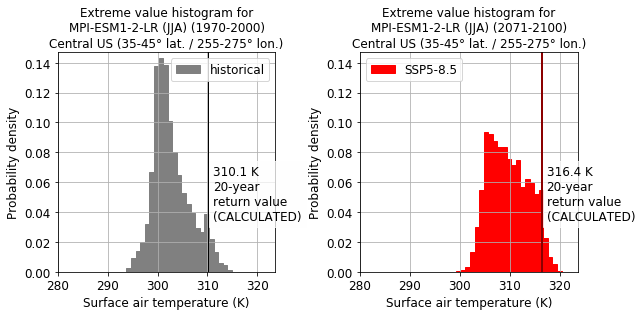

In [204]:
fig = mp.figure(figsize=(9,4.5))
fontsize=12

if return_period >30: t_offset = -5; horiz_align='right'
else:  t_offset = 1; horiz_align='left'

max_val = numpy.max([numpy.max(ssp_histogram), numpy.max(hist_histogram)])

ax1 = fig.add_subplot(121)
ax1.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0.5', edgecolor='0.5', label='historical')
ax1.set_xlim(bins[0], bins[-1]*1.01)
ax1.set_ylim(0, max_val*1.025)
ax1.tick_params(labelsize=fontsize)
ax1.set_ylabel('Probability density', fontsize=fontsize)
ax1.set_xlabel('Surface air temperature (K)', fontsize=fontsize)
ax1.set_title('Extreme value histogram for\n'+model_name+' ('+season+')'+' ('+hist_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax1.grid()
ax1.axvline(return_val_hist, lw=1, c='0')
t1=ax1.text(s='{:.1f}'.format(return_val_hist)+' K\n'+str(return_period)+'-year\nreturn value\n(CALCULATED)', \
           ha=horiz_align, va='top', x=return_val_hist+t_offset, y=max_val/2, fontsize=fontsize)
t1.set_bbox(dict(color='2', alpha=0.75))


handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax2 = fig.add_subplot(122)
ax2.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', edgecolor='red', label=scenario)
ax2.set_xlim(bins[0], bins[-1]*1.01)
ax2.set_ylim(0, max_val*1.025)
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel('Probability density', fontsize=fontsize)
ax2.set_xlabel('Surface air temperature (K)', fontsize=fontsize)
ax2.set_title('Extreme value histogram for\n'+model_name+' ('+season+')'+' ('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax2.grid()
ax2.axvline(return_val_ssp, lw=2, c='darkred')
t1=ax2.text(s='{:.1f}'.format(return_val_ssp)+' K\n'+str(return_period)+'-year\nreturn value\n(CALCULATED)', \
           ha=horiz_align, va='top', x=return_val_ssp+t_offset, y=max_val/2, fontsize=fontsize)
t1.set_bbox(dict(color='1', alpha=0.75))

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

fig.tight_layout()

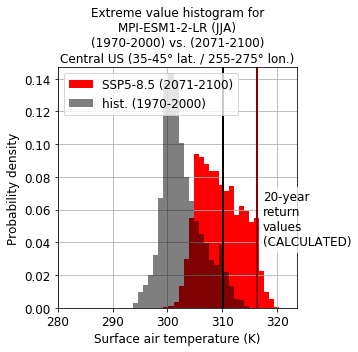

In [205]:
fig = mp.figure(figsize=(5,5))
fontsize=12

ax = fig.add_subplot(111)
ax.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0', lw=0, label='hist. ('+hist_years+')', zorder=1, alpha=0.5)
ax.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', lw=0, label=scenario +' ('+ssp_years+')', zorder=0, alpha=1)
ax.set_xlim(bins[0], bins[-1]*1.01)
ax.set_ylim(0, max_val*1.025)
ax.set_ylabel('Probability density', fontsize=fontsize)
ax.set_xlabel('Surface air temperature (K)', fontsize=fontsize)
ax.set_title('Extreme value histogram for\n'+model_name+' ('+season+')\n'+'('+hist_years+') vs. ('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)

ax.tick_params(labelsize=fontsize)

ax.axvline(return_val_hist, lw=2, c='0')
ax.axvline(return_val_ssp, lw=2, c='darkred')
t=ax.text(s=str(return_period)+'-year\nreturn\nvalues\n(CALCULATED)', \
           ha='left', va='top', x=max(return_val_hist,return_val_ssp)+1, y=max_val/2, fontsize=fontsize)
t.set_bbox(dict(color='1', alpha=0.75))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax.grid()
ax.set_axisbelow(True)
fig.tight_layout()